# Rocket Trajectory Analysis
This analysis is conducted using Julia.

In [100]:
# Load packages
using Plots, LaTeXStrings, Unitful, ISAData, DifferentialEquations

# Mass Analysis
The rocket has the following masses:
- Dry Mass: 
- Prop Mass:
- Payload Mass:

The propellant reduces as a function of time based on the mass flow rates.

In [101]:
# Define parameters
m_d = 50; # Structural mass
m_f = 28; # Propellant/fuel mass
m_p = 50; # Payload mass
ṁ_f = 2.05323; # Propellant/fuel mass flow rate

g = 9.81; # gravity [m/s^2]
r = ustrip(uconvert(u"m", 4u"inch"));
A = pi*(0.1016^2); # Rocket cross-sectional area [m^2]
c_d = 0.6745; # Rocket drag coefficient

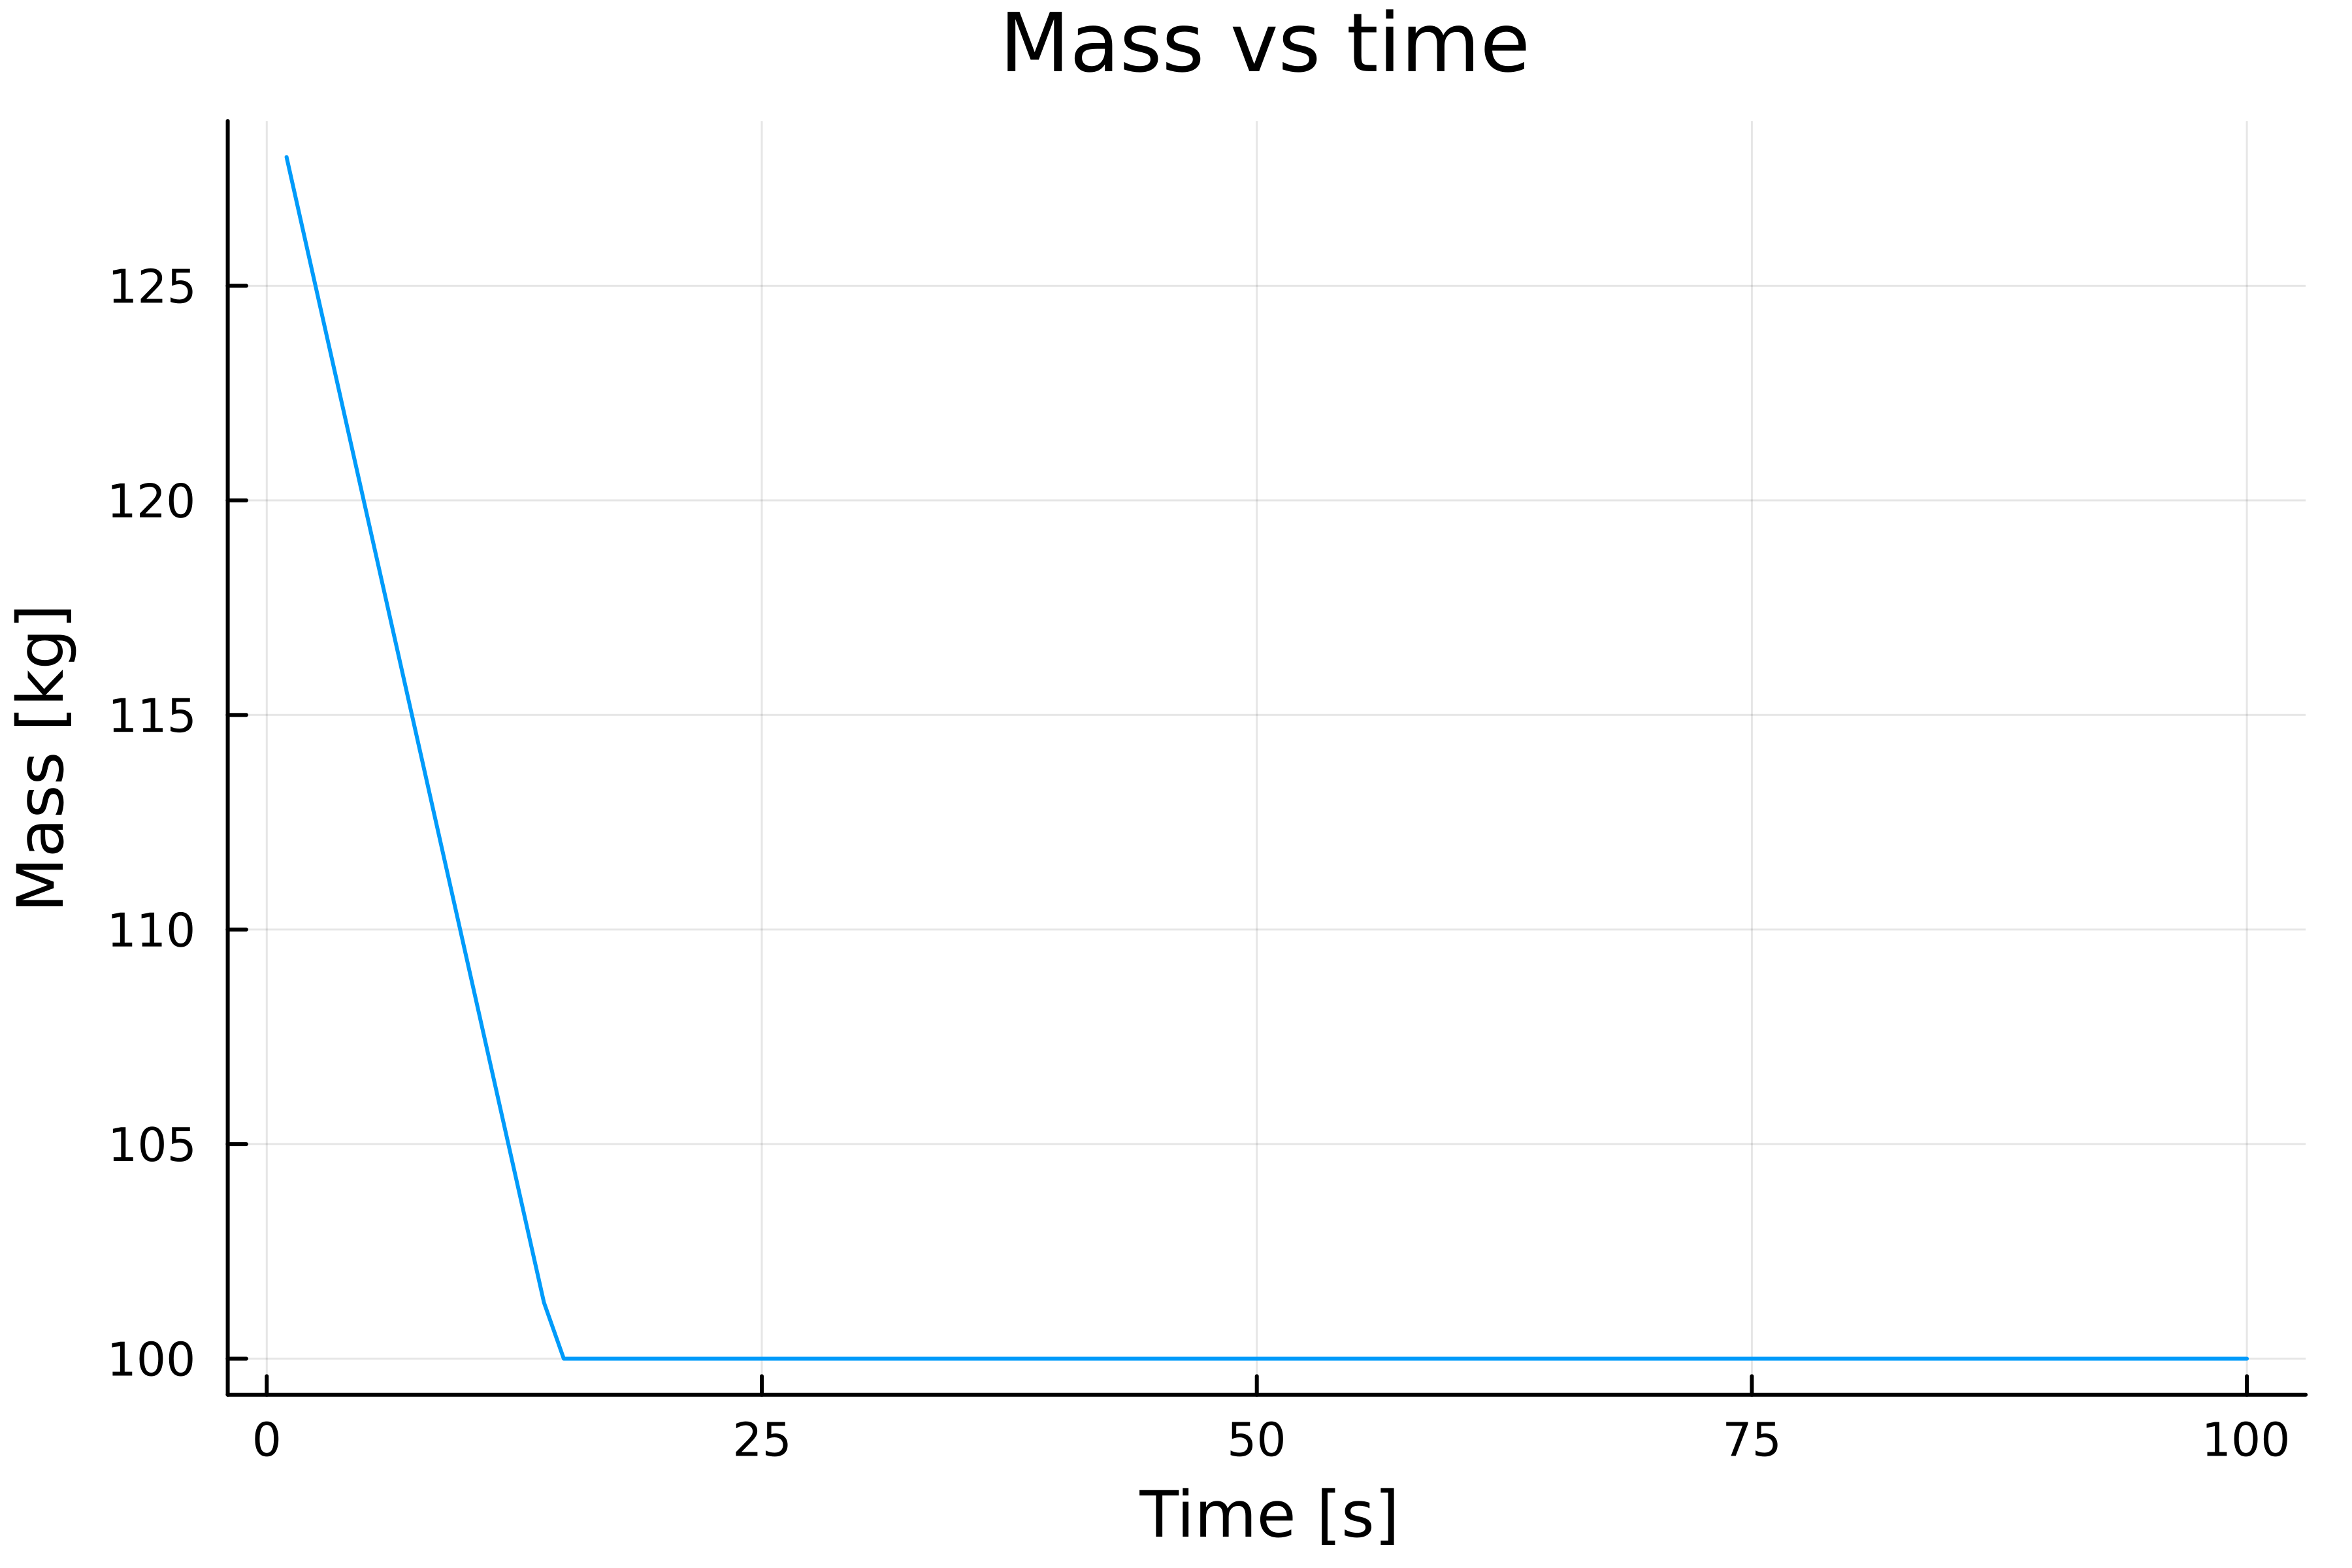

In [102]:
# Mass vs time Plots
Δt = 1; # timestep in seconds
tspan = 1:Δt:100; # Tspan in seconds
mass = zeros(length(tspan)); # mass as a function of time
for t in tspan
    if t == 1 # set initial condition
        mass[t] = m_d + m_f + m_p;
    else
        mass[t] = max(m_d + m_p, mass[t-1] - ṁ_f * Δt);
    end 
end

plot(tspan, mass);
ylabel!("Mass [kg]");
xlabel!("Time [s]");
title!("Mass vs time");
massplot = plot!(legend=false, dpi=600)

# Flight Trajectory
We assume perfect vertical flight (aka no disturbances due to wind).

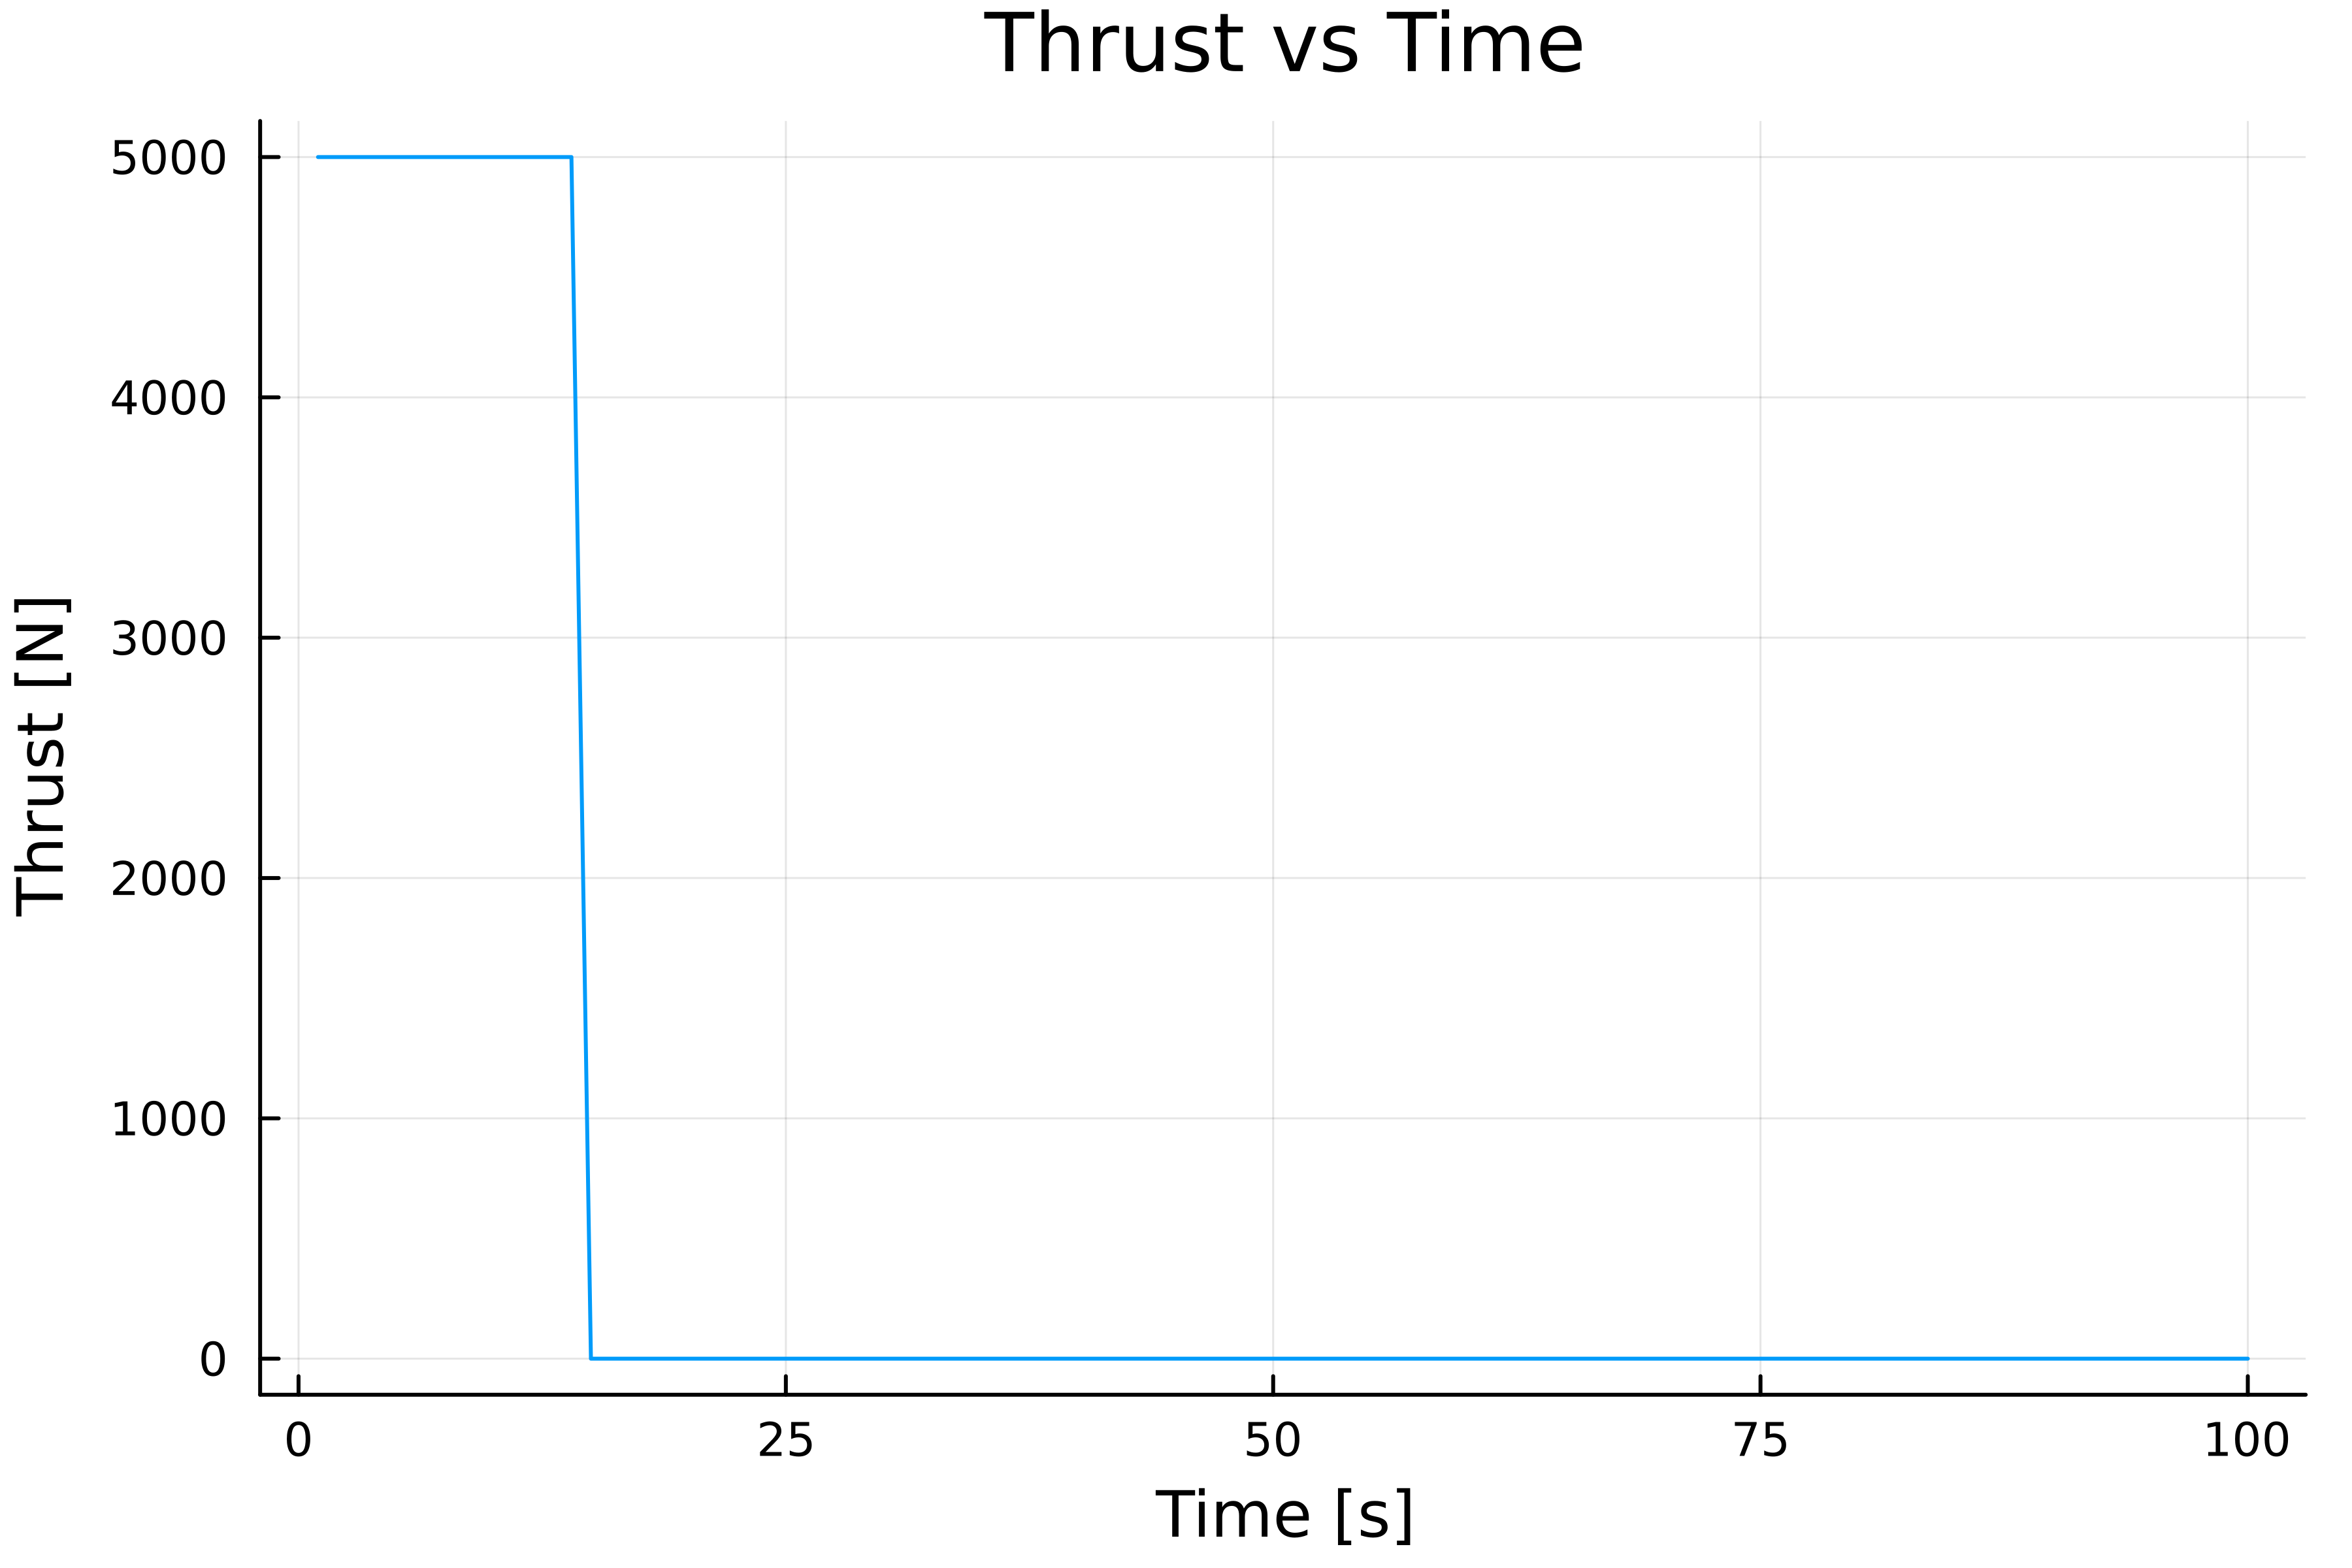

In [103]:
# Thrust function
thrust = ones(length(tspan))*5000; # Thrust in Newtons
thrust[mass .== m_d + m_p] .= 0;
plot(tspan, thrust);
title!("Thrust vs Time");
xlabel!("Time [s]");
ylabel!("Thrust [N]");
thrustplot = plot!(legend=false, dpi=600)

In [104]:
# Drag function
function drag(ρ, c_d, v, A)
    return 0.5*ρ*c_d*A*(v^2);
end

# Initialize state variables
alt = zeros(length(tspan)); # altitude as a function of time
vel = zeros(length(tspan)); # velocity as a function of time
accel = zeros(length(tspan)); # acceleration as a function of time
time = 1;
for time in tspan
    if time == 1
        accel[time] = 0;
        vel[time] = 0;
        alt[time] = 0;
    else # compute velocity and altitude via euler method
        ρ, P, T, μ = ISAdata(alt[time]); # Compute atmospheric values at altitude
        accel[time] = (thrust[time] - mass[time]*g - sign(vel[time-1])*drag(ρ,c_d,vel[time-1],A))/mass[time];
        vel[time] = vel[time-1] + accel[time]*Δt;
        alt[time] = max(0, alt[time-1] + vel[time]*Δt);

        if alt[time] == 0
            accel[time] = 0;
            vel[time] = 0;
        end
    end
end

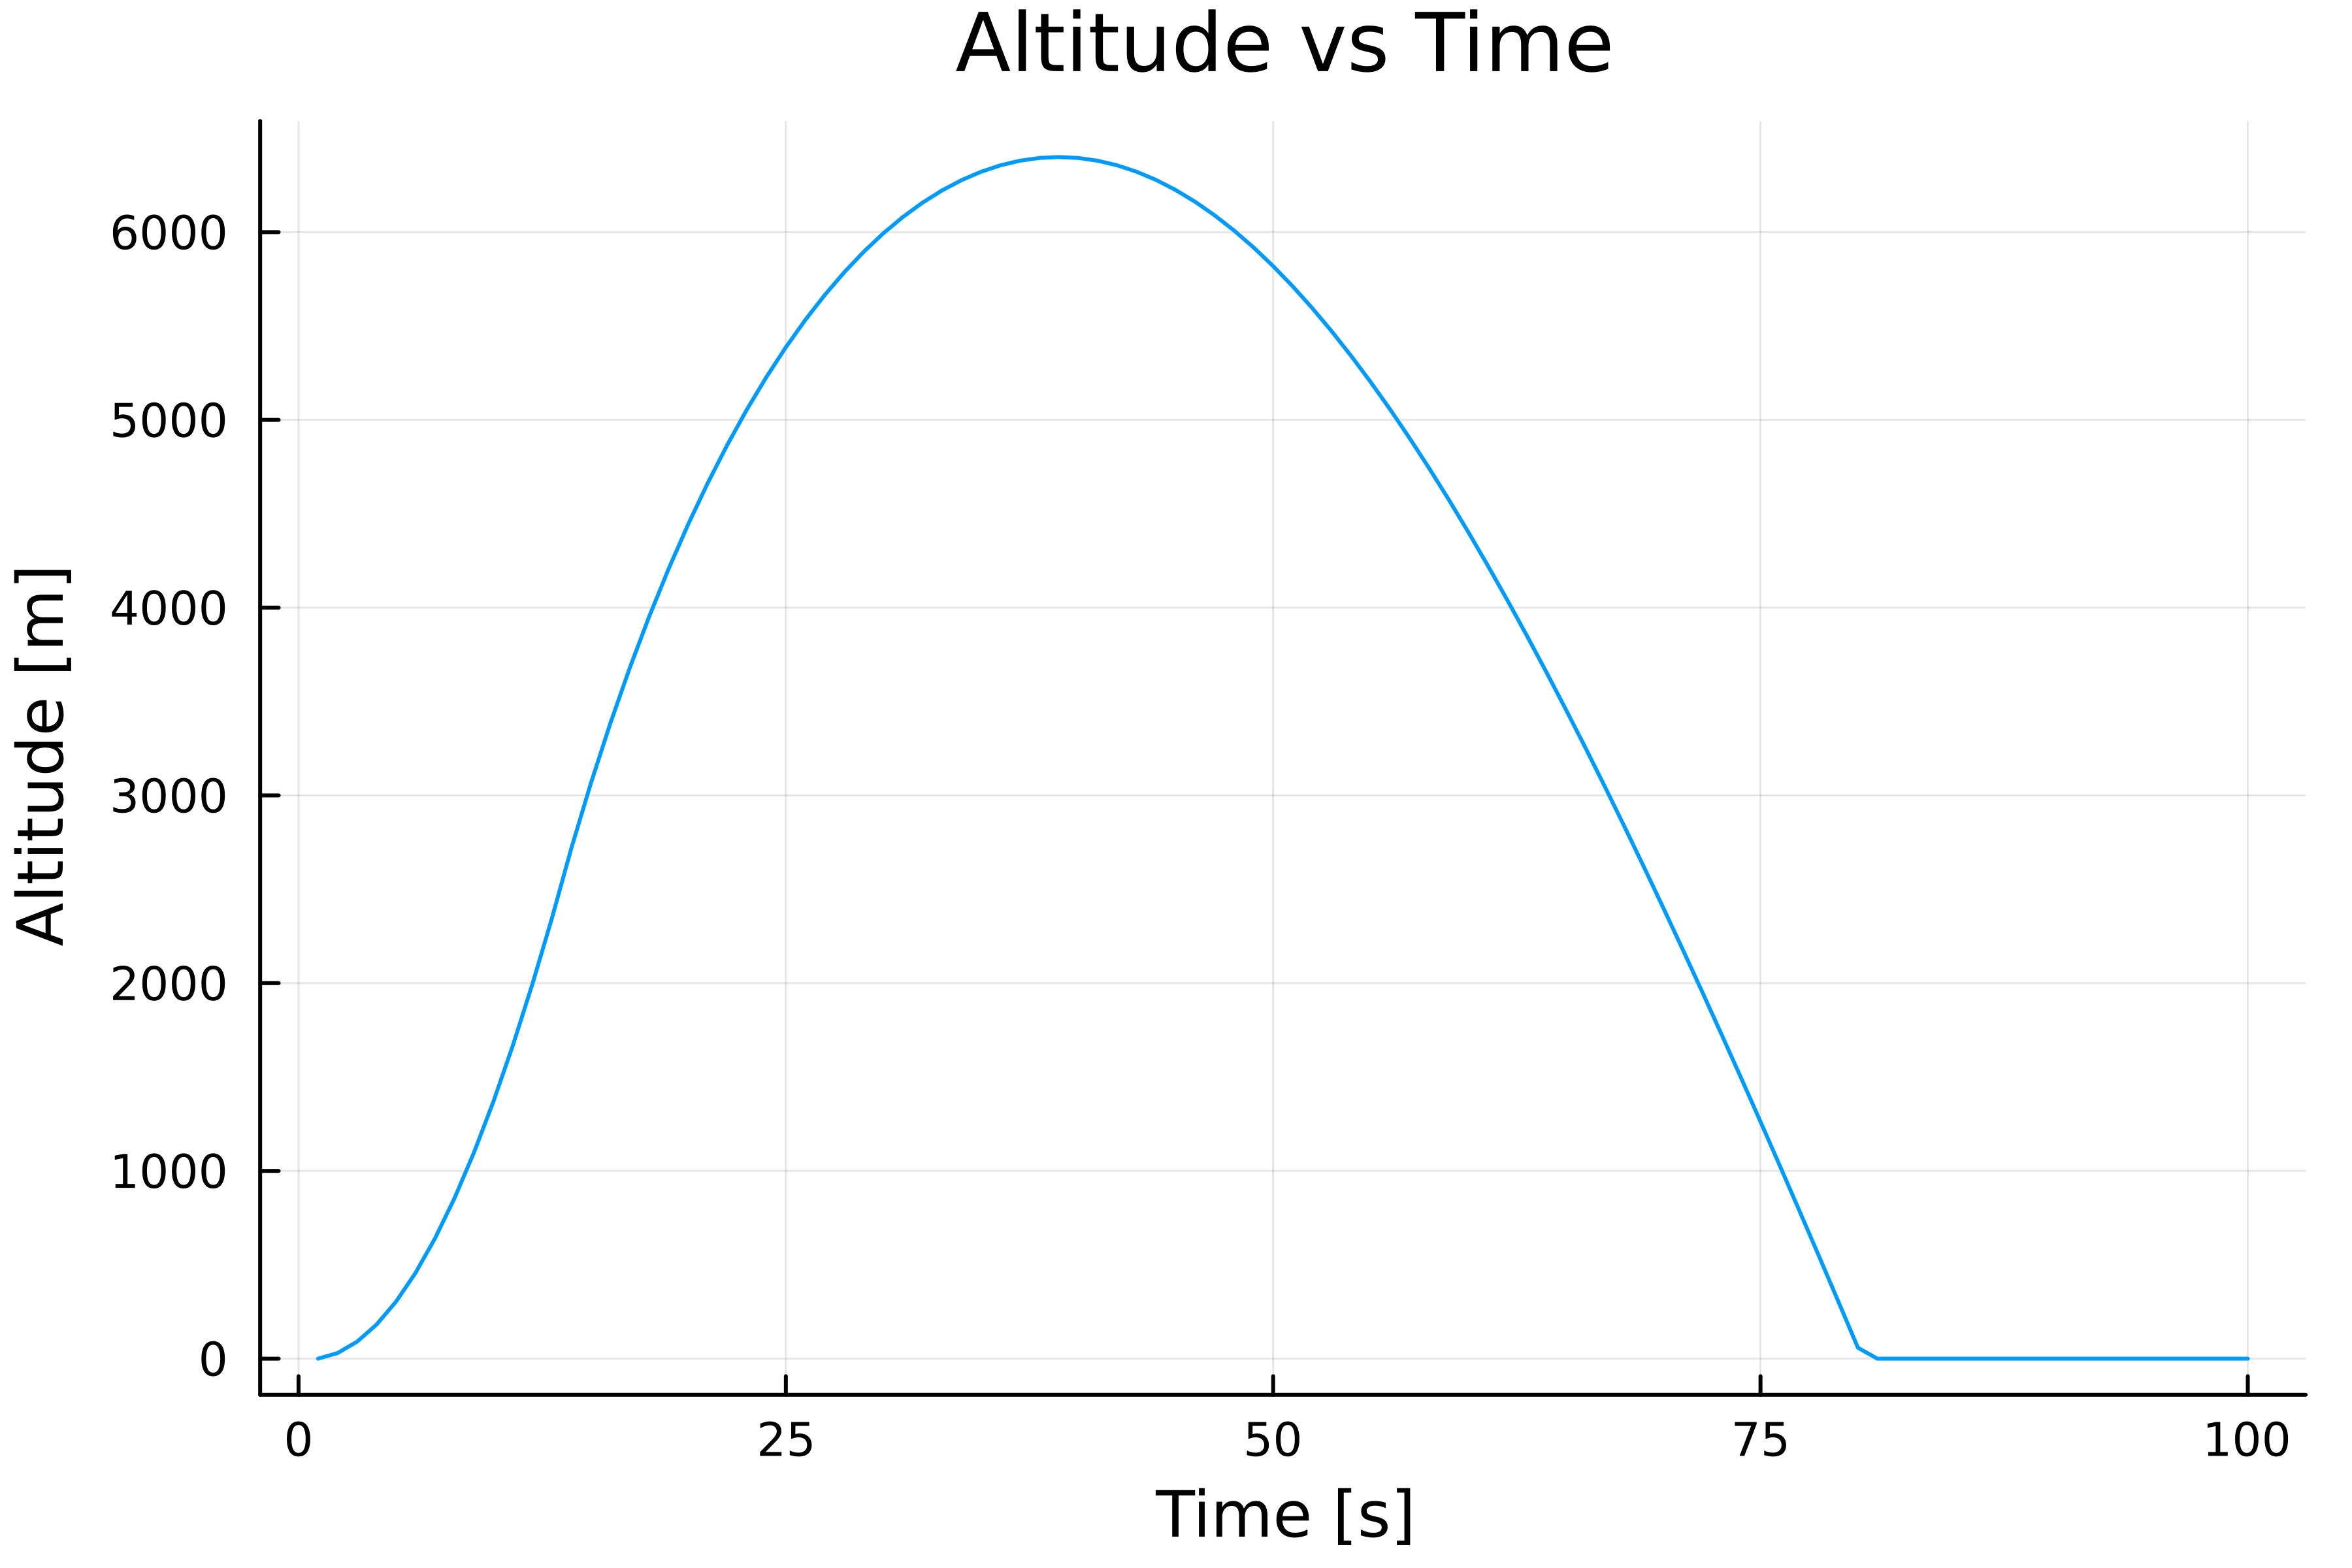

In [105]:
# Plot Altitude vs Time
plot(tspan, alt);
title!("Altitude vs Time");
xlabel!("Time [s]");
ylabel!("Altitude [m]");
altplot = plot!(legend=false, dpi=600)

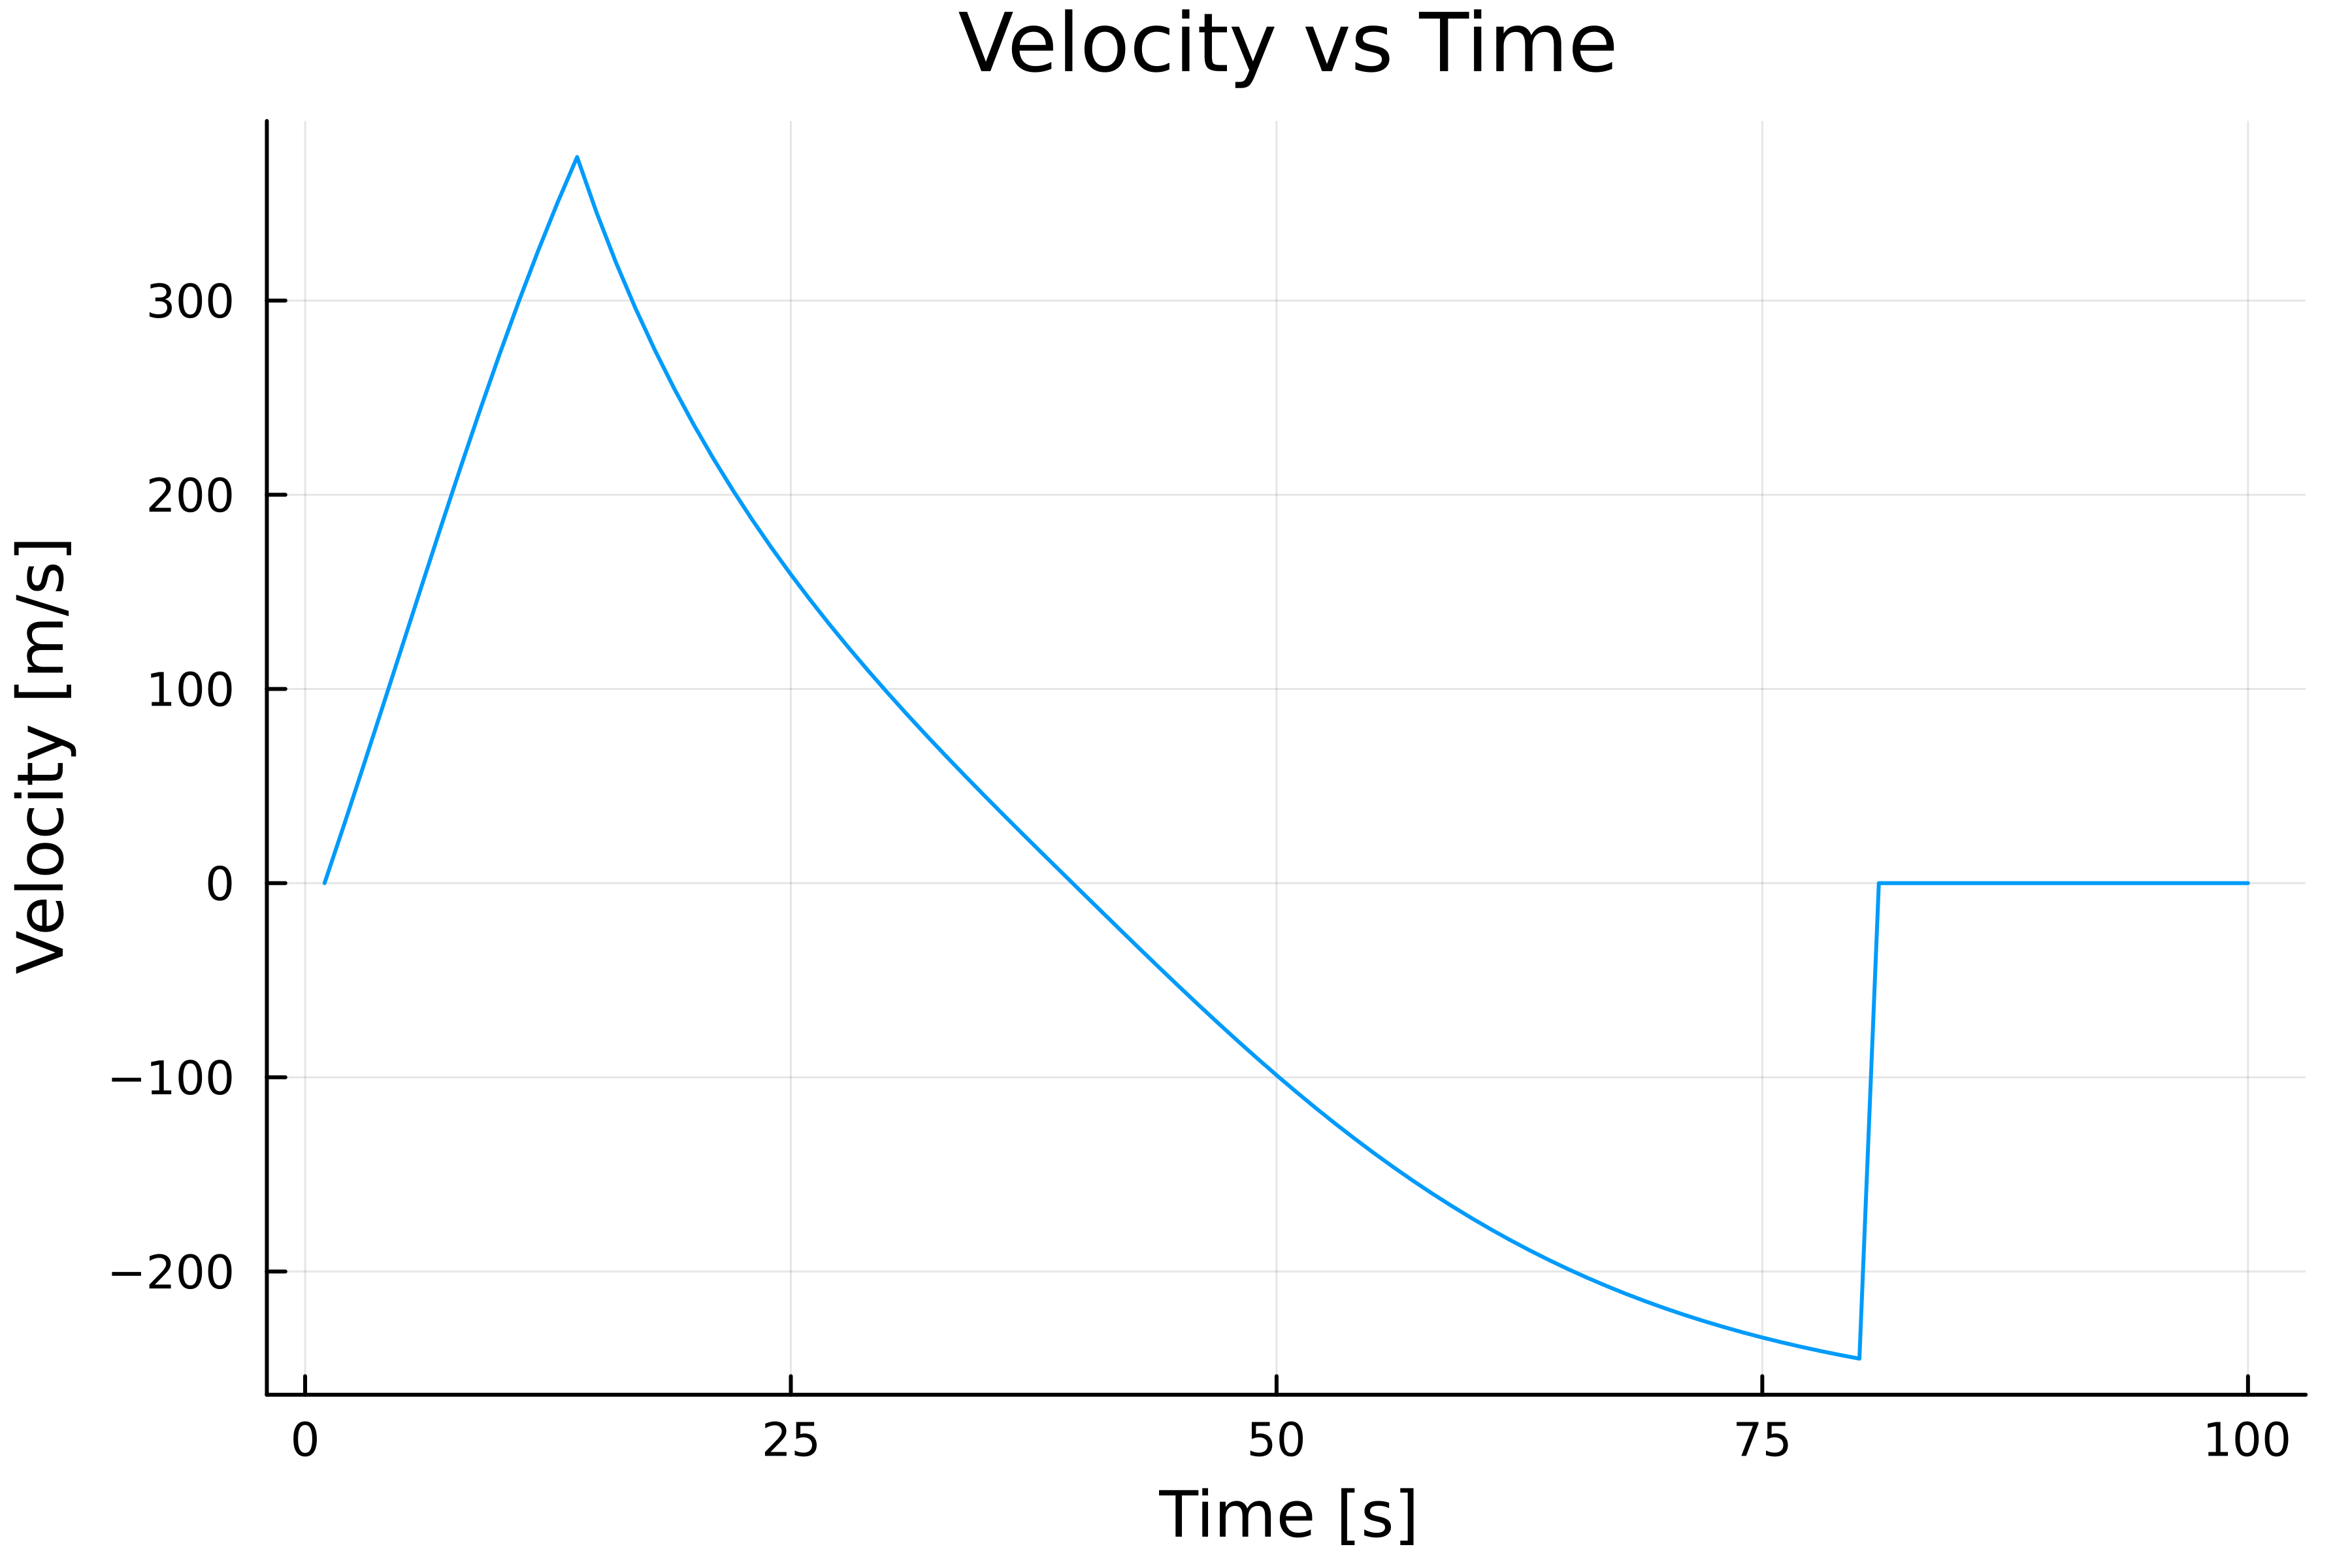

In [106]:
# Plot Velocity vs Time
plot(tspan, vel);
title!("Velocity vs Time");
xlabel!("Time [s]");
ylabel!("Velocity [m/s]");
velplot = plot!(legend=false, dpi=600)

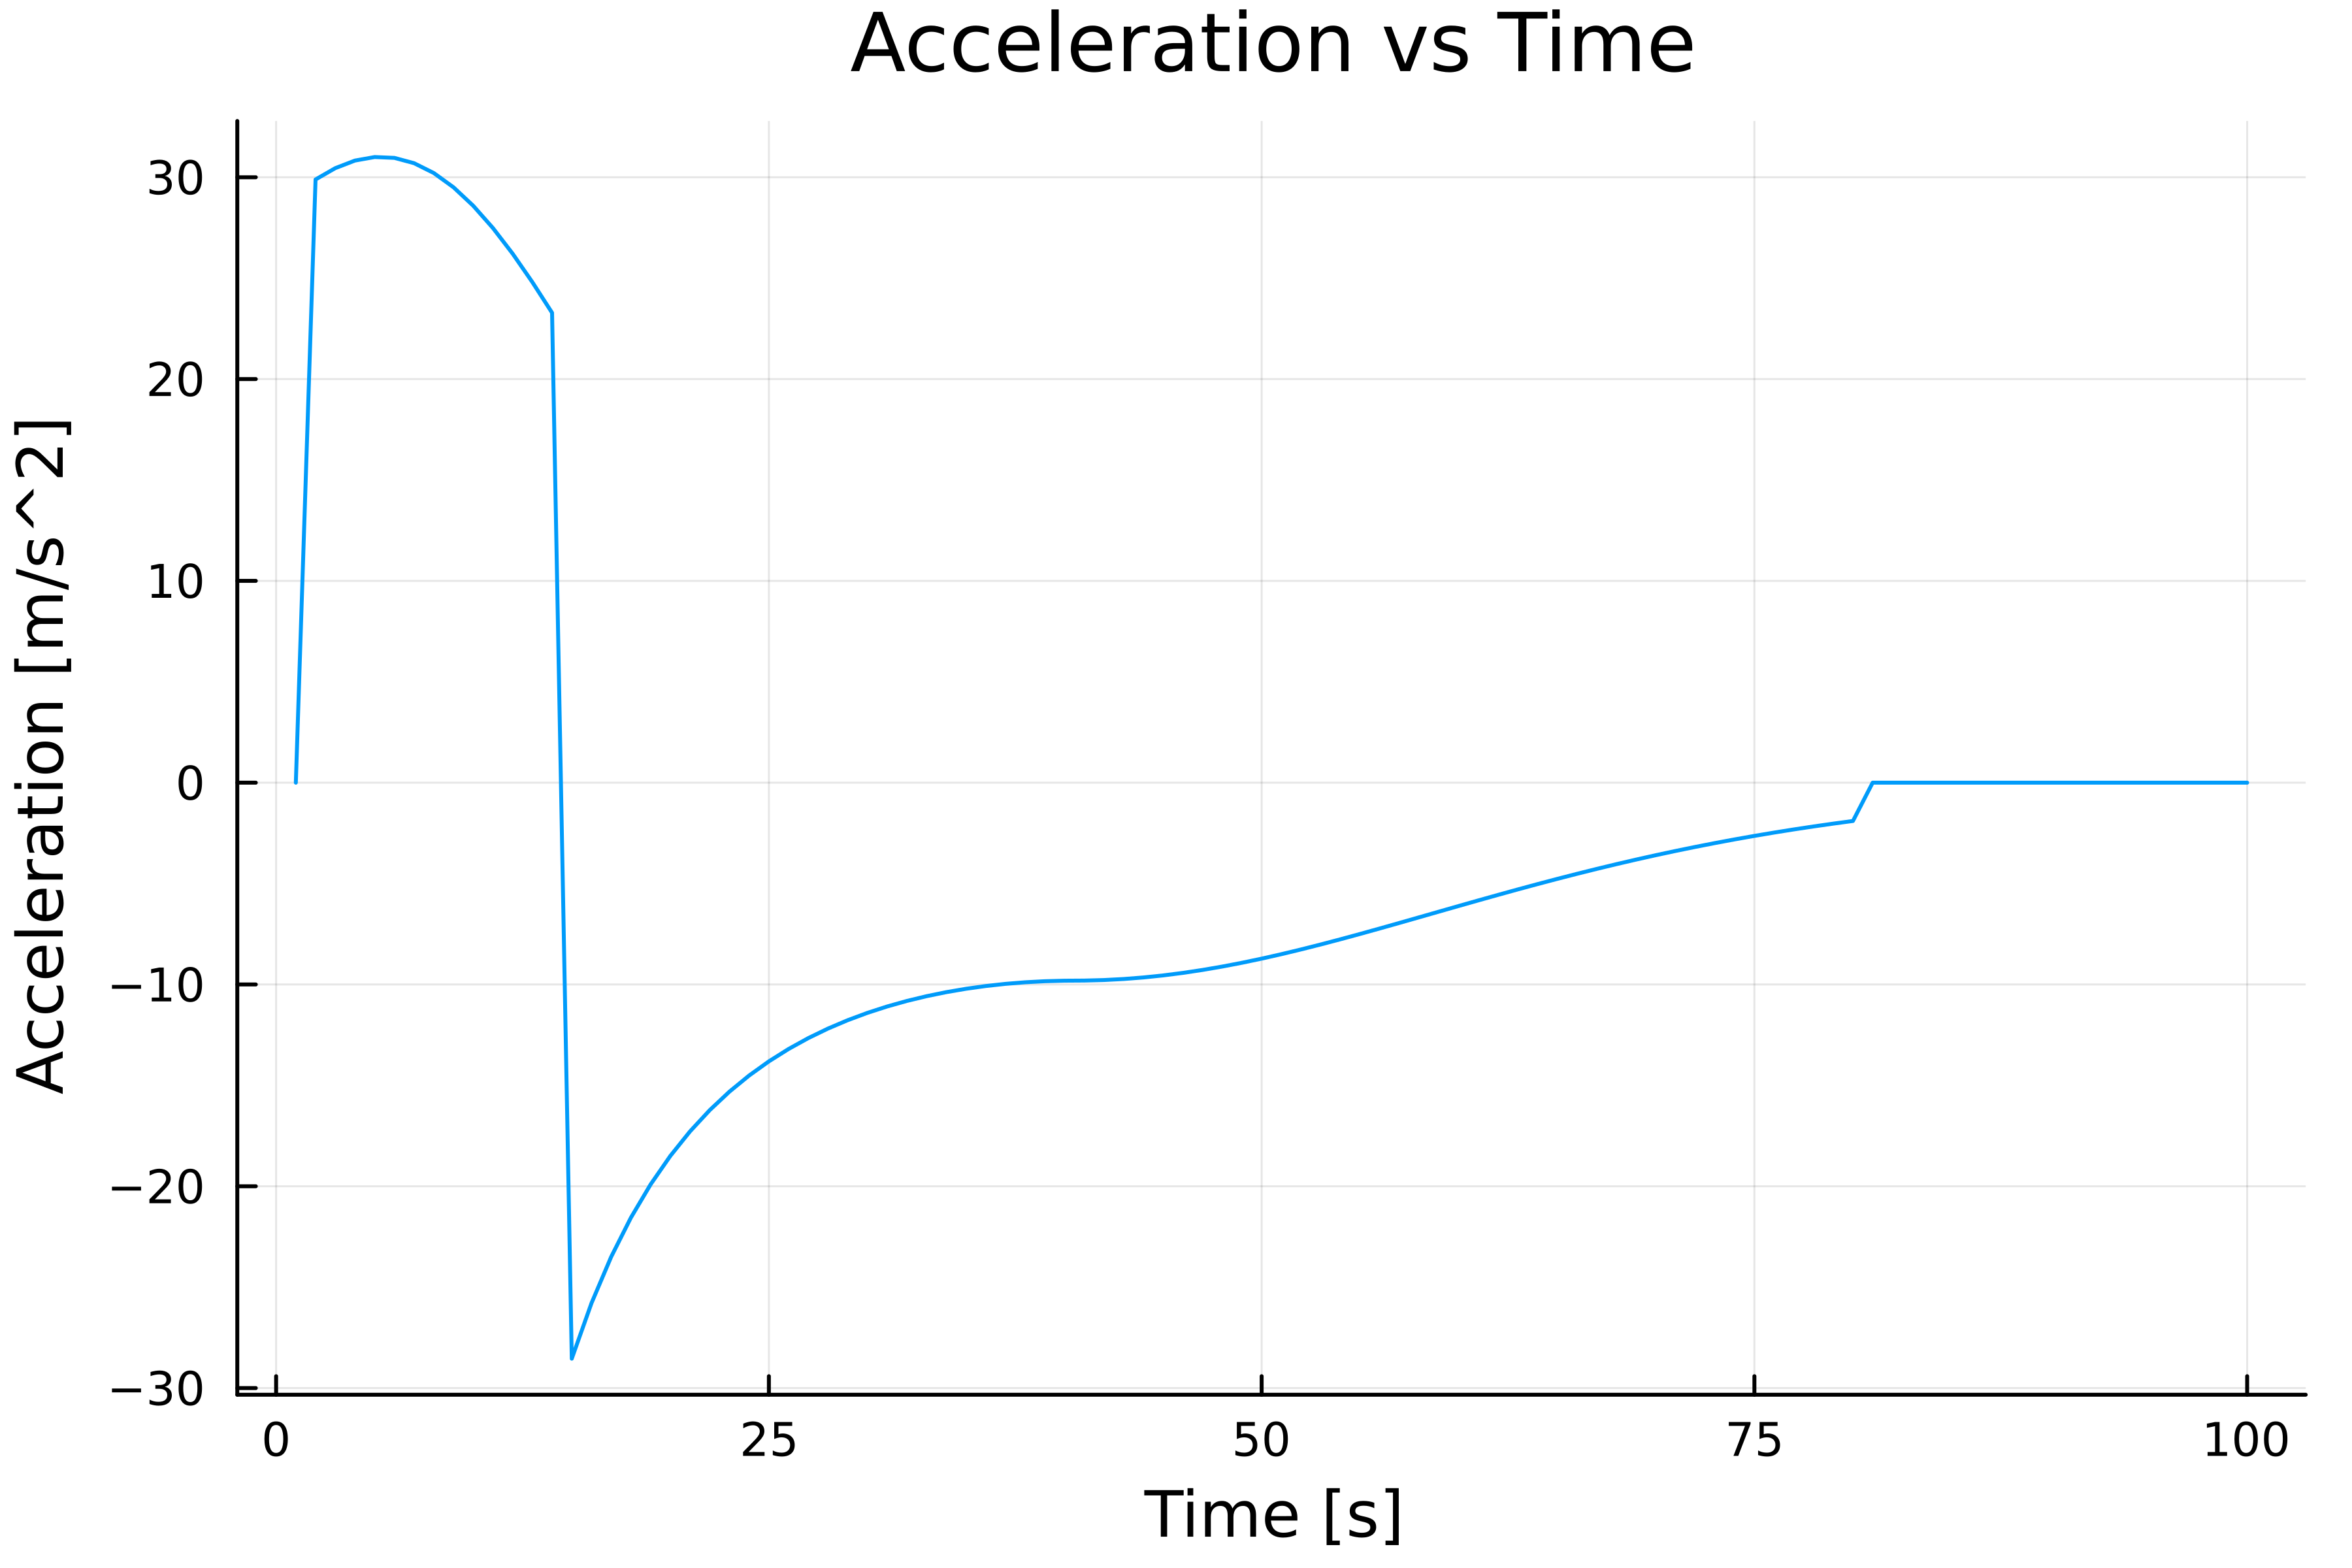

In [107]:
# Plot Acceleration vs Time
plot(tspan, accel, label="Acceleration");
# hline!([maximum(accel)], linestyle=:dash, label="Maximum Acceleration");
title!("Acceleration vs Time");
xlabel!("Time [s]");
ylabel!("Acceleration [m/s^2]");
accplot = plot!(legend=false, dpi=600)

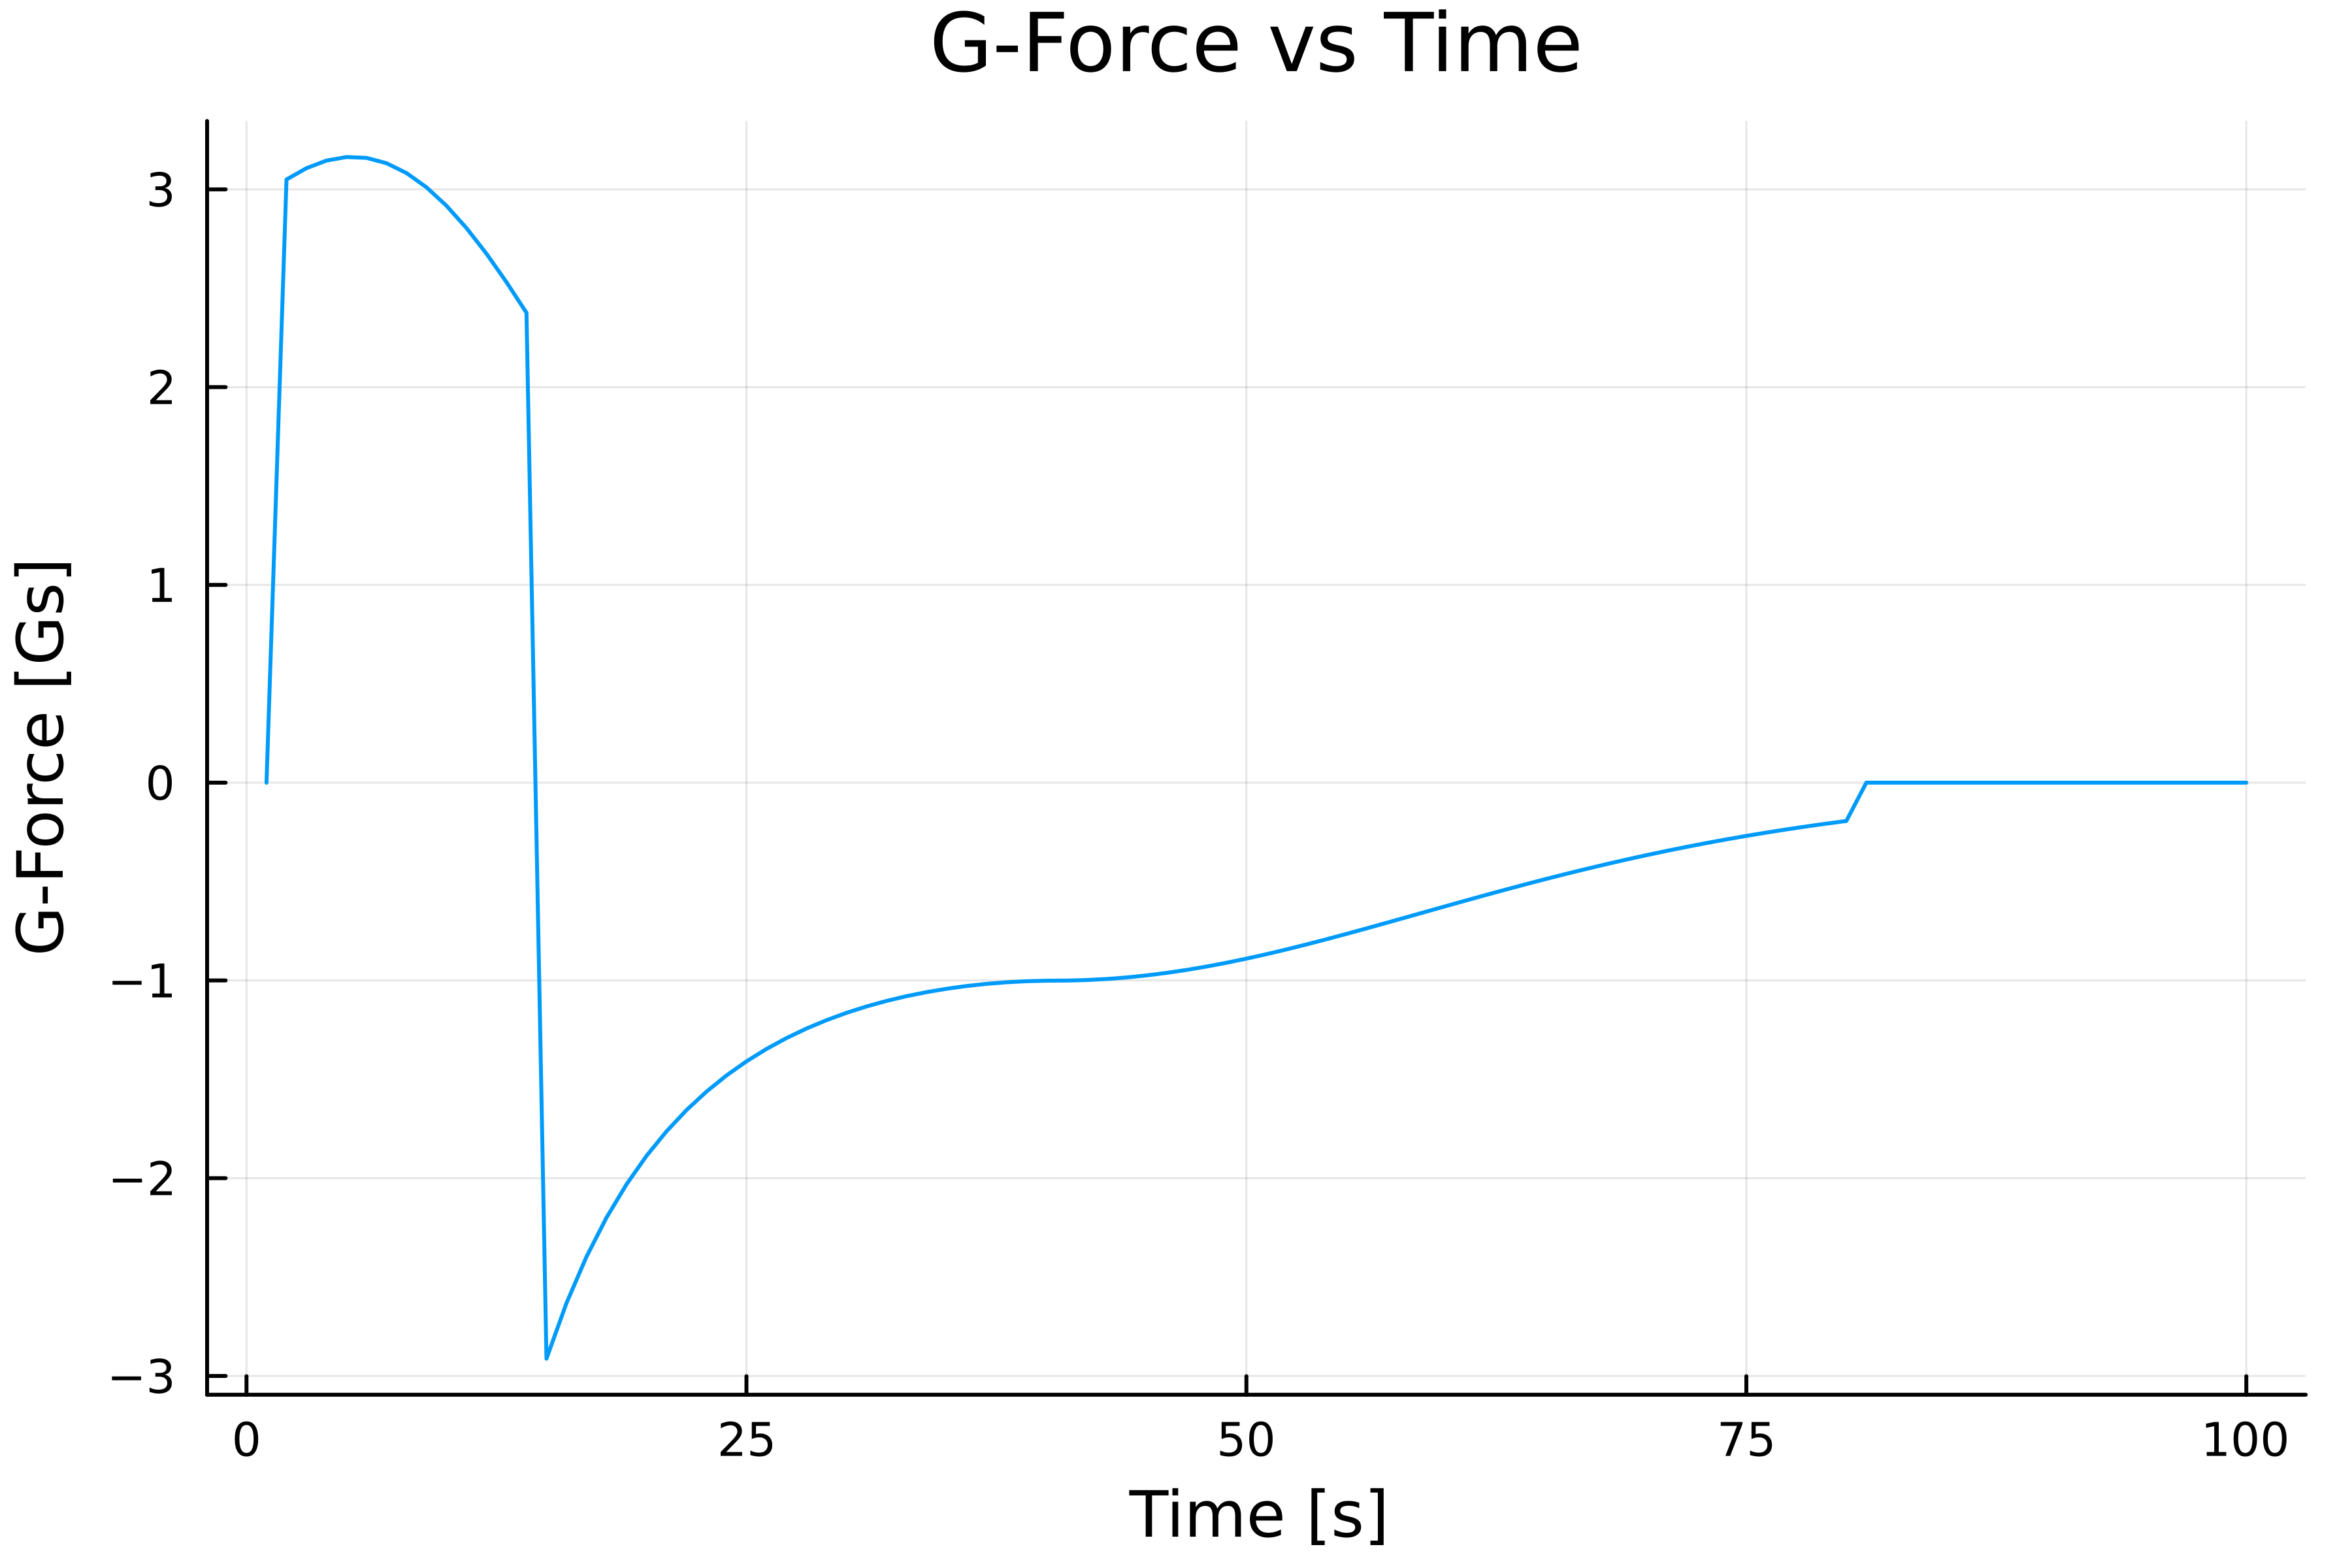

In [108]:
# G-Force vs Time
# Plot Acceleration vs Time
plot(tspan, accel./(9.8));
title!("G-Force vs Time");
xlabel!("Time [s]");
ylabel!("G-Force [Gs]");
gplot = plot!(legend=false, dpi=600)

We can now compute the dynamic pressure at each point using the formula
$$
q = \frac{1}{2}\rho u^2
$$

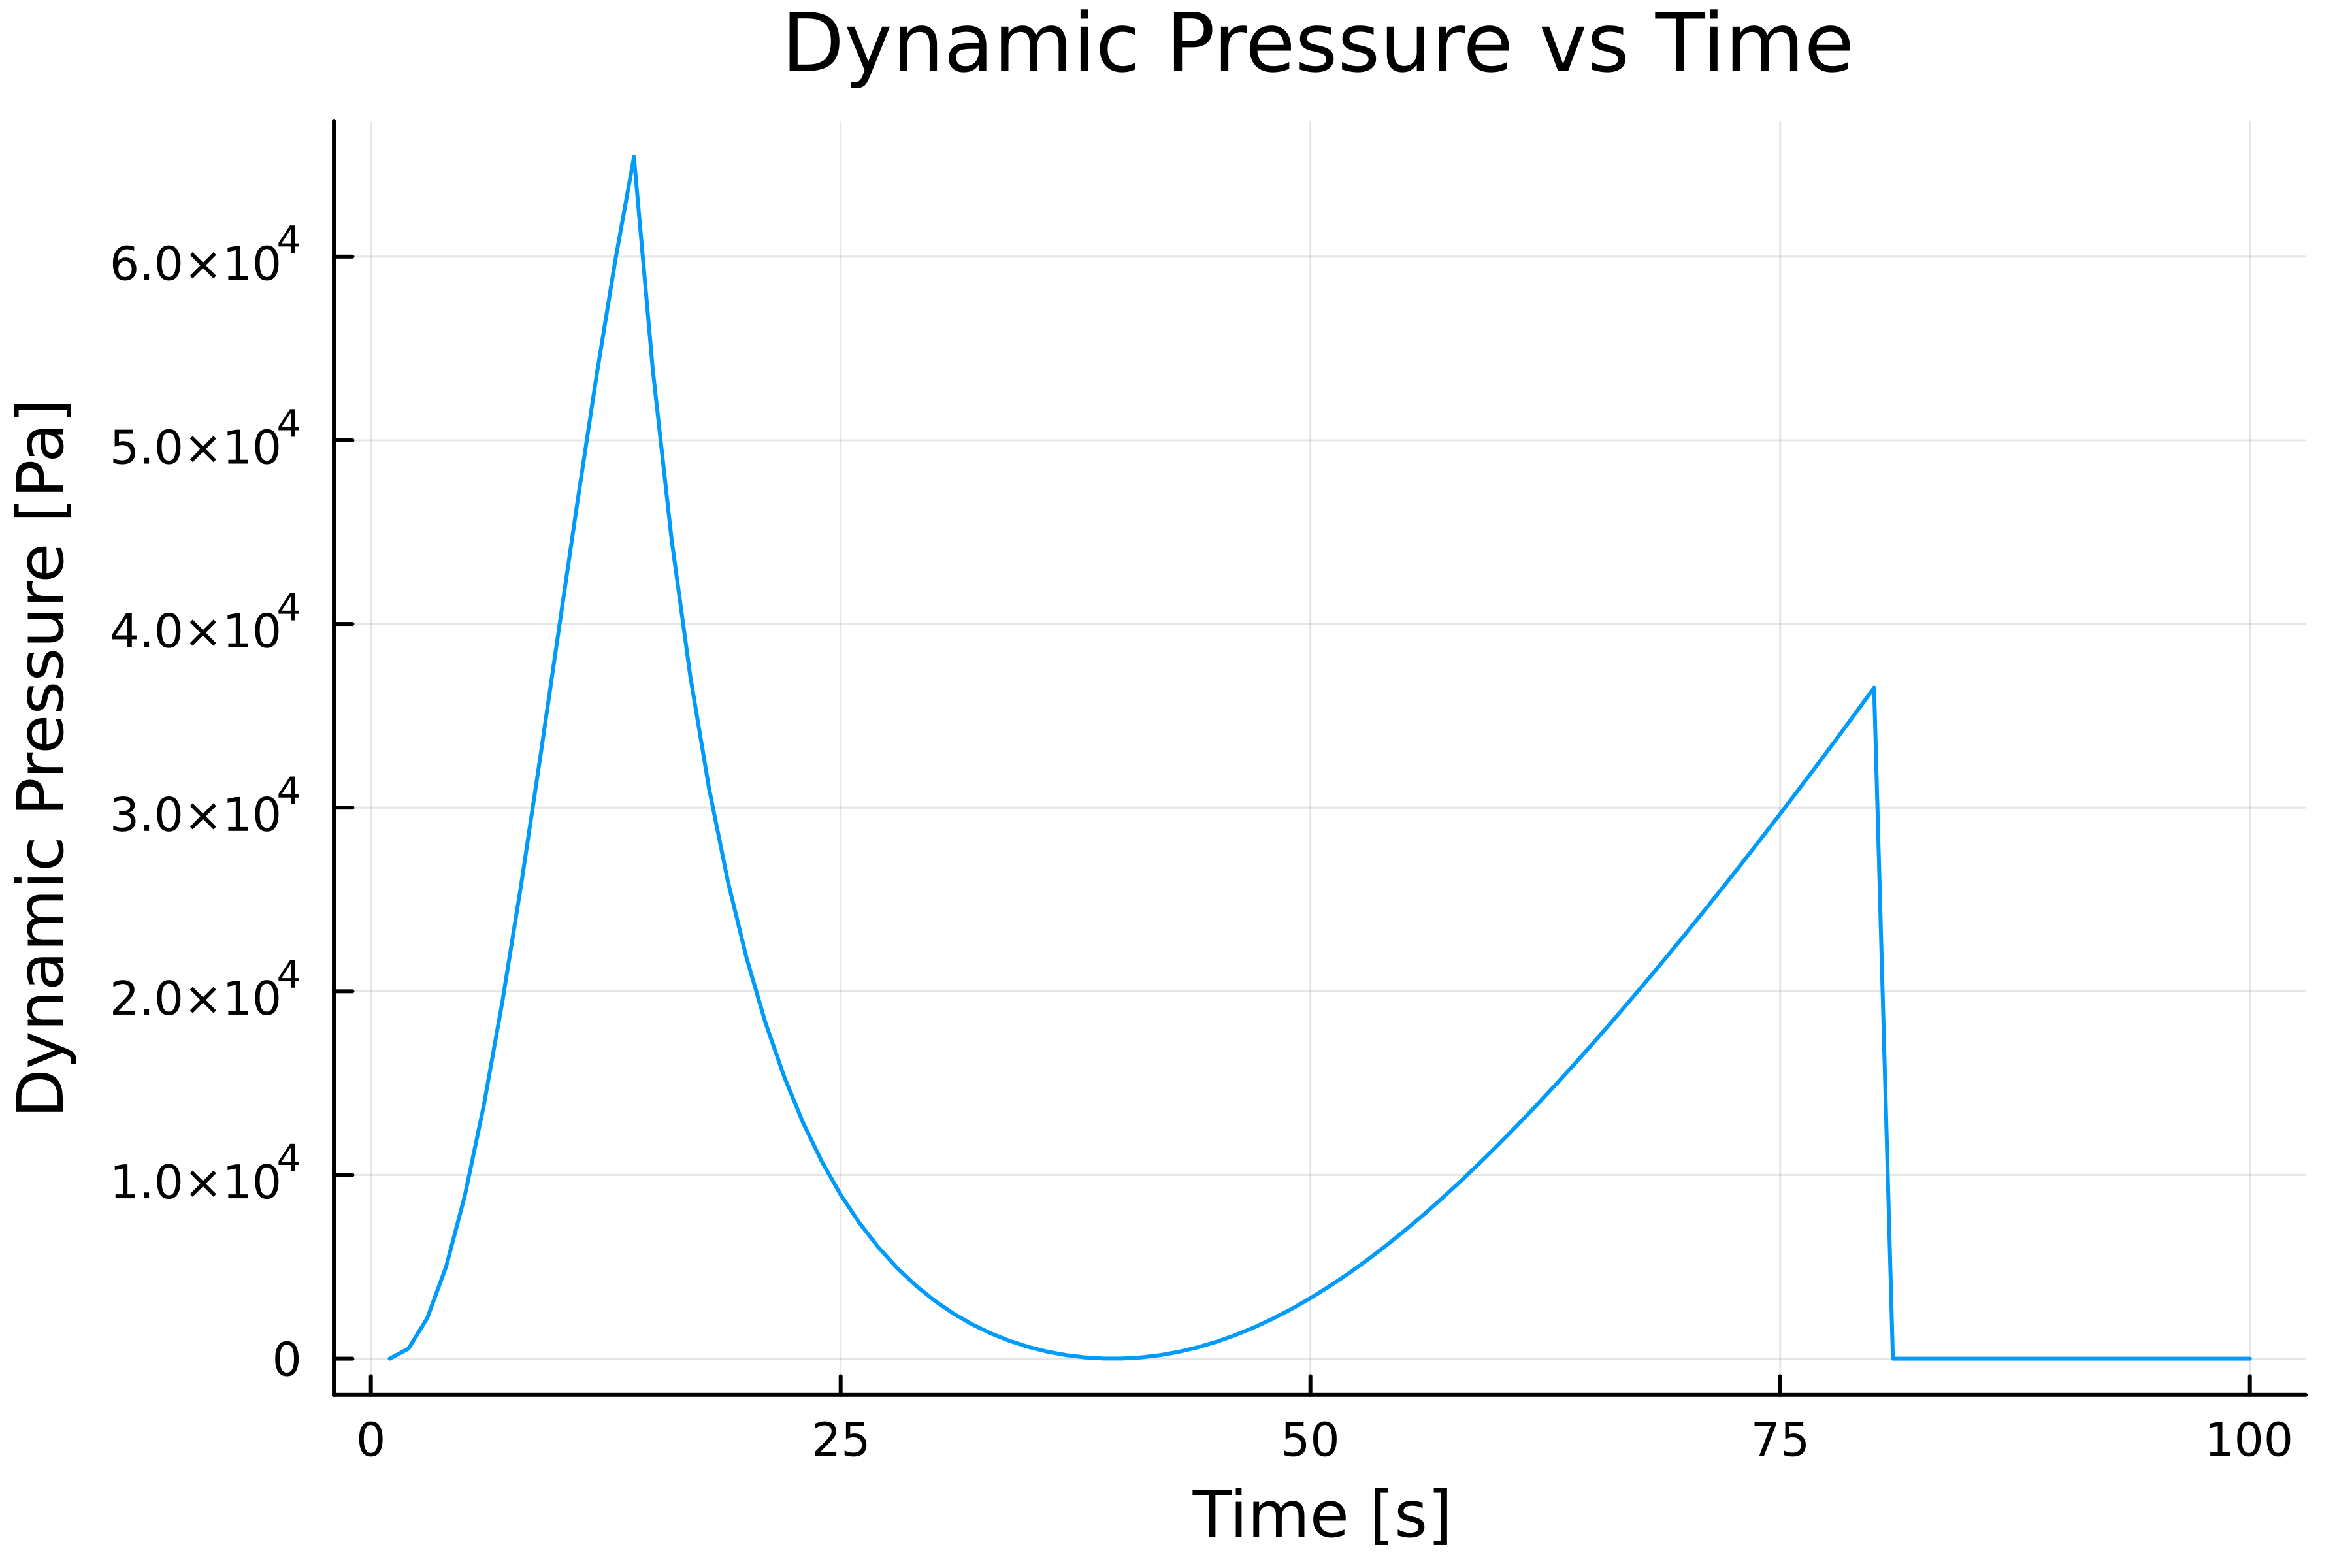

In [109]:
q = zeros(length(tspan));
for time in tspan
    ρ, P, T, μ = ISAdata(alt[time]);
    q[time] = 0.5*ρ*(vel[time]^2);
end
plot(tspan, q);
title!("Dynamic Pressure vs Time");
xlabel!("Time [s]");
ylabel!("Dynamic Pressure [Pa]");
qplot = plot!(legend=false, dpi=600)

In [110]:
# Maximum dynamic pressure
println(maximum(q[1:50]));

65422.197398323035


In [111]:
# Maximum altitude
println(maximum(alt));

6399.886460219609


In [112]:
# Save plots
savefig(massplot, joinpath("fig", "mass_v_time.png"));
savefig(thrustplot, joinpath("fig", "thrust_v_time.png"));
savefig(altplot, joinpath("fig", "altitude_v_time.png"));
savefig(velplot, joinpath("fig", "vel_v_time.png"));
savefig(accplot, joinpath("fig", "acc_v_time.png"));
savefig(gplot, joinpath("fig", "g_v_time.png"));
savefig(qplot, joinpath("fig", "q_v_time.png"));